# Baysian TWFE

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [7]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

# 特定の列の外れ値を除去する例
column = 'population_change_rate'

# 平均と標準偏差の計算
mean = df[column].mean()
std = df[column].std()

# 外れ値の定義（ここでは3標準偏差を超えるデータを外れ値とみなす）
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# 外れ値を除去
df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 除去されたデータを確認
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
outliers

,island_names,years,island_ids,region_codes,region_names,prefecture_codes,populations,treatment_group,treatment_group_mainland,year_bridges_opened,...,cohort_2000,years_cohort_2000,cohort_2004,years_cohort_2004,cohort_2011,years_cohort_2011,cohort_2015,years_cohort_2015,cohort_2016,years_cohort_2016
5,鹿久居島,2000,68,33342,日生町,33,16,1,1,2015,...,0,0,0,0,0,0,1,-15,0,0
30,鴻島,1975,71,33342,日生町,33,76,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,松島,2000,78,33202,倉敷市,33,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,生口島,1995,95,34430,（旧）瀬戸田町,34,11097,1,1,1991,...,0,0,0,0,0,0,0,0,0,0
149,長島,1985,103,34427,（旧）大崎町,34,39,1,0,1987,...,0,0,0,0,0,0,0,0,0,0
152,長島,2000,103,34427,（旧）大崎町,34,33,1,0,1987,...,0,0,0,0,0,0,0,0,0,0
227,沖野島,2000,118,34330,（旧）大柿町,34,7,1,1,1972,...,0,0,0,0,0,0,0,0,0,0
230,沖野島,2015,118,34215,江田島市,34,9,1,1,1972,...,0,0,0,0,0,0,0,0,0,0
243,笠佐島,2005,126,35305,周防大島町,35,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df['passage_of_year'].describe()

count    600.000000
mean       2.603333
std       12.741529
min      -41.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       48.000000
Name: passage_of_year, dtype: float64

In [9]:
population_change_rate = df_cleaned['population_change_rate']
treatment = df_cleaned['treatment_group']
passage_of_year = dmatrix('C(passage_of_year) -1', data=df_cleaned, return_type='dataframe')
islands = dmatrix('C(island_ids) -1', data=df_cleaned, return_type='dataframe')
years = dmatrix('C(years) -1', data=df_cleaned, return_type='dataframe')

n_passage_of_year = passage_of_year.shape[1]
n_islands = islands.shape[1]
n_years = years.shape[1]

## TWFE

$$
Y_{it} = \text{TreatmentGroup} + \text{Year}_t + \text{PassageOfYear}
$$

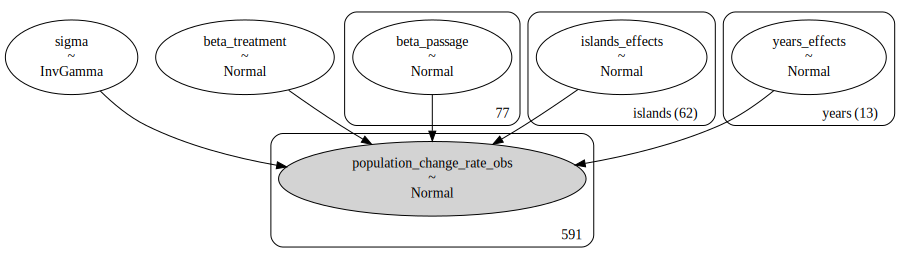

In [10]:
with pm.Model() as model:
    # Priors
    beta_treatment = pm.Normal('beta_treatment', mu=0, sigma=100)
    beta_passage = pm.Normal('beta_passage', mu=0, sigma=100, shape=n_passage_of_year)
    islands_effects = pm.Normal('islands_effects', mu=0, sigma=100, shape=n_islands, dims='islands')
    years_effects = pm.Normal('years_effects', mu=0, sigma=100, shape=n_years, dims='years')
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # linear model
    mu = beta_treatment * treatment + pm.math.dot(years, years_effects) + pm.math.dot(passage_of_year, beta_passage) + pm.math.dot(islands, islands_effects)

    # Likelihood
    population_change_rate_obs = pm.Normal('population_change_rate_obs', mu=mu, sigma=sigma, observed=population_change_rate)

# モデルの視覚化
pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample(
        draws=8000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        init="adapt_diag",
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [62]:
az.to_netcdf(idata, 'bm_twfe.nc')

'bm_twfe.nc'

In [8]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,-4.611,27.139,-58.774,46.766,0.451,0.319,3621.0,5891.0,1.0
beta_passage[0],7.774,23.874,-38.904,54.230,0.368,0.261,4200.0,8574.0,1.0
beta_passage[1],-16.628,21.144,-56.425,26.636,0.316,0.223,4487.0,7838.0,1.0
beta_passage[2],7.308,22.525,-35.990,52.218,0.371,0.262,3685.0,7787.0,1.0
beta_passage[3],14.818,21.141,-25.788,57.487,0.316,0.223,4482.0,7898.0,1.0
...,...,...,...,...,...,...,...,...,...
years_effects[9],1.876,19.427,-36.550,39.466,0.347,0.245,3139.0,4876.0,1.0
years_effects[10],-6.485,19.426,-42.930,33.061,0.347,0.246,3131.0,5030.0,1.0
years_effects[11],-7.199,19.443,-43.676,32.624,0.348,0.246,3125.0,4925.0,1.0
years_effects[12],-11.674,19.431,-48.987,27.335,0.347,0.245,3138.0,4949.0,1.0


In [55]:
az.summary(idata, var_names=['beta_passage'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_passage[0],7.528,24.204,-40.440,53.893,0.354,0.251,4661.0,8913.0,1.0
beta_passage[1],-17.364,21.225,-57.692,25.130,0.383,0.271,3072.0,7081.0,1.0
beta_passage[2],7.019,22.914,-37.262,51.786,0.351,0.248,4262.0,7799.0,1.0
beta_passage[3],13.954,21.353,-29.198,54.281,0.387,0.273,3054.0,6924.0,1.0
beta_passage[4],4.555,22.877,-39.731,49.686,0.352,0.249,4241.0,8052.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_passage[72],-1.720,26.063,-52.498,49.621,0.364,0.257,5124.0,8332.0,1.0
beta_passage[73],3.309,24.861,-44.217,53.456,0.349,0.247,5064.0,9333.0,1.0
beta_passage[74],-5.735,22.198,-49.198,37.708,0.364,0.258,3712.0,8398.0,1.0
beta_passage[75],2.865,25.969,-48.746,53.053,0.362,0.256,5151.0,8712.0,1.0


array([[<Axes: title={'center': 'beta_treatment'}>,
        <Axes: title={'center': 'beta_treatment'}>],
       [<Axes: title={'center': 'beta_passage'}>,
        <Axes: title={'center': 'beta_passage'}>],
       [<Axes: title={'center': 'islands_effects'}>,
        <Axes: title={'center': 'islands_effects'}>],
       [<Axes: title={'center': 'years_effects'}>,
        <Axes: title={'center': 'years_effects'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

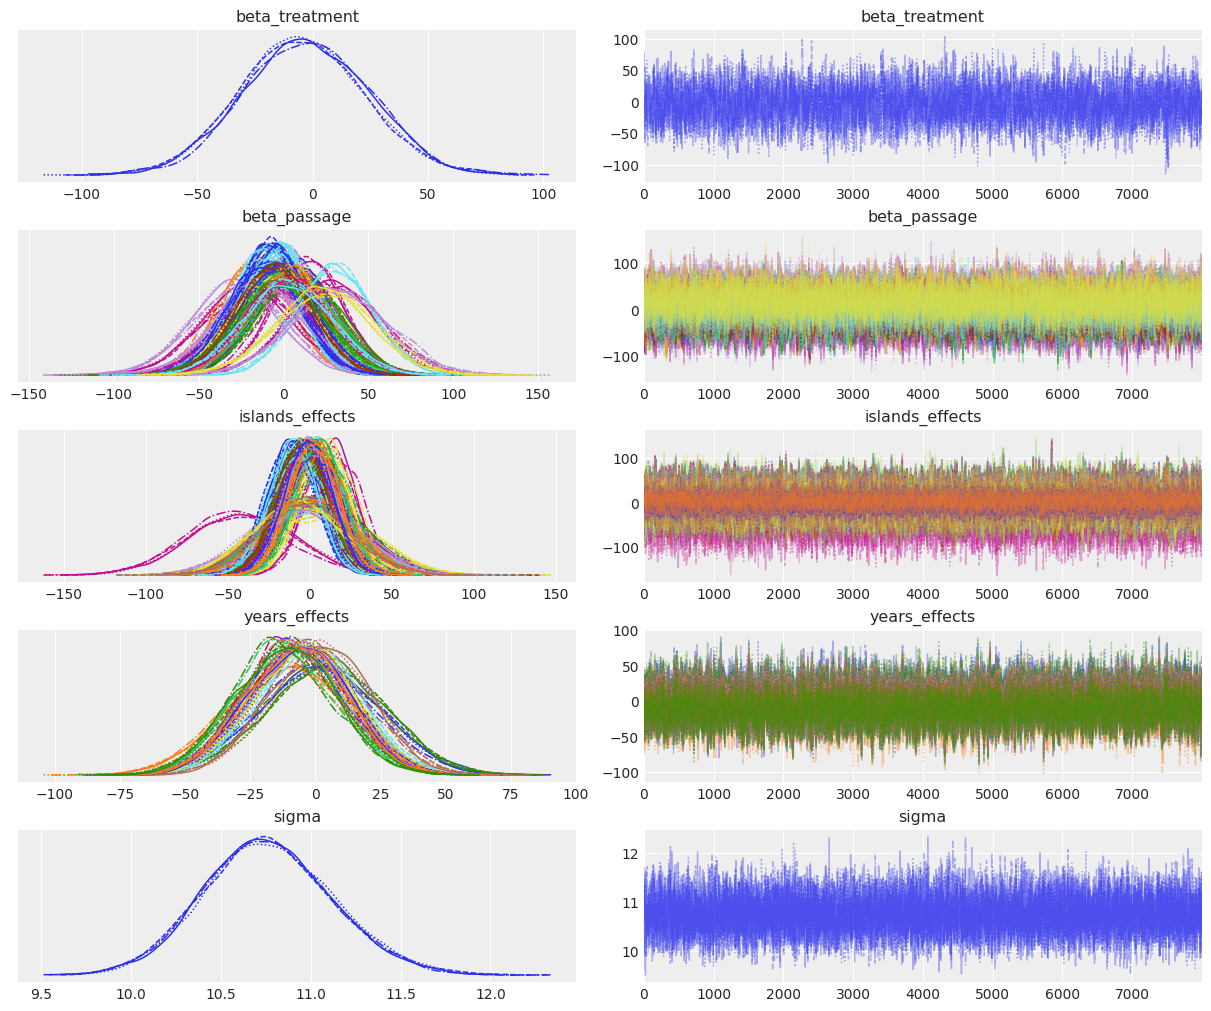

In [27]:
az.plot_trace(idata)

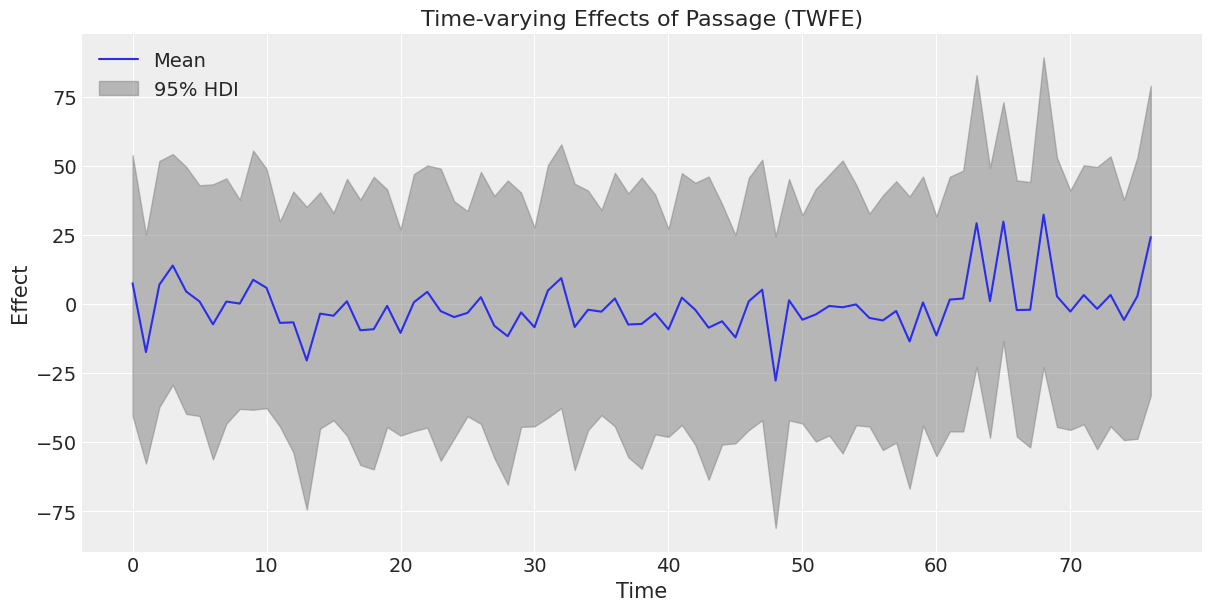

In [ ]:
# beta_passageの事後分布を抽出
beta_passage_posterior = idata.posterior['beta_passage']

# 事後分布の平均と信用区間を計算
beta_passage_mean = beta_passage_posterior.mean(dim=["chain", "draw"]).values
beta_passage_hdi = az.hdi(beta_passage_posterior, hdi_prob=0.95)

# HDIの下限と上限を抽出
beta_passage_hdi_lower = beta_passage_hdi.sel(hdi='lower').to_array().values.flatten()
beta_passage_hdi_upper = beta_passage_hdi.sel(hdi='higher').to_array().values.flatten()

# プロットの作成
plt.figure(figsize=(12, 6))
plt.plot(beta_passage_mean, label='Mean')
plt.fill_between(
    range(len(beta_passage_mean)),
    beta_passage_hdi_lower,
    beta_passage_hdi_upper,
    color='gray', alpha=0.5, label='95% HDI'
)

plt.xlabel('Time')
plt.ylabel('Effect')
plt.title('Time-varying Effects of Passage (TWFE)')
plt.legend()
plt.show()

In [2]:
idata = az.from_netcdf('./bm_twfe_sampling.nc')

In [8]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_passage'] > 0)
print(f"Pr(beta_passage > 0) = {prob_beta_bridge_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_passage > 0) = 0.4786
Pr(sigma > 0) = 1.0000


In [11]:
with model:
    pm.compute_log_likelihood(idata)

az.loo(idata)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 32000 posterior samples and 591 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2326.92    26.70
p_loo      126.94        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      553   93.6%
   (0.70, 1]   (bad)        36    6.1%
   (1, Inf)   (very bad)    2    0.3%